In [1]:
# Imports
import networkx as nx
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
# Filter to just the US
airports_csv = pd.read_csv('../../data/openFlightsRaw/airports.csv')
usRoutes_csv = pd.read_csv('../../data/usRoutesClean.csv')


US_AirportsData = airports_csv.merge(usRoutes_csv, how="inner", left_on='AIRPT_ID', right_on='SRC_AIRPT_ID')
US_AirportsData = US_AirportsData[US_AirportsData['CTRY'] == 'United States']

In [18]:
# Add columns that show how many total incoming and outgoing routes that row's SRC airport has
airportPopularityIncoming = pd.DataFrame({"IATA": [], "INCOMING": []})
airportPopularityOutgoing = pd.DataFrame({"IATA": [], "OUTGOING": []})

airportPopularityIncoming['IATA'] = usRoutes_csv['DESTINIATA']
airportPopularityIncoming['INCOMING'] = airportPopularityIncoming.groupby('IATA')['IATA'].transform('count')

airportPopularityOutgoing['IATA'] = usRoutes_csv['SRCIATA']
airportPopularityOutgoing['OUTGOING'] = airportPopularityOutgoing.groupby('IATA')['IATA'].transform('count')

airportPopularityIncoming = airportPopularityIncoming.drop_duplicates()
airportPopularityOutgoing = airportPopularityOutgoing.drop_duplicates()



In [19]:
# Create the network so that we can get our additional routes that could be used to get from our start to finish
G = nx.from_pandas_edgelist(US_AirportsData, 'SRCIATA', 'DESTINIATA', create_using=nx.DiGraph())

In [20]:
# Target Start Location Variable
startAirport = 'LAX'

# Target End Location Variable
endAirport = 'ATL'

# Create Optimal Path String for Later
optimalPath = "['"+startAirport+"', '"+endAirport+"']"

# Set up the data set to have distance values (as the crow flies) to be able to do hierarchical clustering in regards to the amount of stops and total distance for the route.
routes = pd.DataFrame({"PATH": [], "STOPS": [], "TOTAL_DIST": [], "TOTAL_TIME": [], "ROUTE_VERSATILITY_SCORE": []})
highestVersatilityScore = 0
paths = nx.all_simple_paths(G, startAirport, endAirport, cutoff=3)
for path in paths: # Let's work only with data that would only result in 2 or less additional airport stops
    nodeLocation = 0
    totalDistance = 0
    totalTime = 0
    versatilityScore = 0
    for index in path:
        # Update versatility score (how many routes leave the start airport, how many arrive and leave for intermediate airports, and how many arrive for the end airport)
        if (nodeLocation != 0) & (nodeLocation < len(path) - 1):
            versatilityScore = versatilityScore + (airportPopularityOutgoing.loc[airportPopularityOutgoing['IATA'] == index, 'OUTGOING'].values)[0]
        # Calculate total distance of the route as the crow flies
        currentIATA = index
        if nodeLocation != 0:
            totalDistance = totalDistance + (US_AirportsData.loc[(US_AirportsData['SRCIATA'] == pastIATA) & (US_AirportsData['DESTINIATA'] == currentIATA), 'meters'].values)[0]
            totalTime = totalTime + (US_AirportsData.loc[(US_AirportsData['SRCIATA'] == pastIATA) & (US_AirportsData['DESTINIATA'] == currentIATA), 'seconds'].values)[0]
        nodeLocation = nodeLocation + 1
        pastIATA = index
    versatilityScore = versatilityScore / len(path) # Penalize longer routes
    totalTime = totalTime + ((len(path) - 2) * (60 * 90)) # Penalize routes with connections to account for layover time. Giving a flat 90 minutes of average layover time for each additional stop.
    # Keep track of the highest score to assign to the optimal route
    routes_Entry = pd.DataFrame({"PATH": [path], "STOPS": [len(path) - 2], "TOTAL_DIST": [totalDistance], "TOTAL_TIME": [totalTime], "ROUTE_VERSATILITY_SCORE": [versatilityScore]})
    routes = pd.concat([routes, routes_Entry])

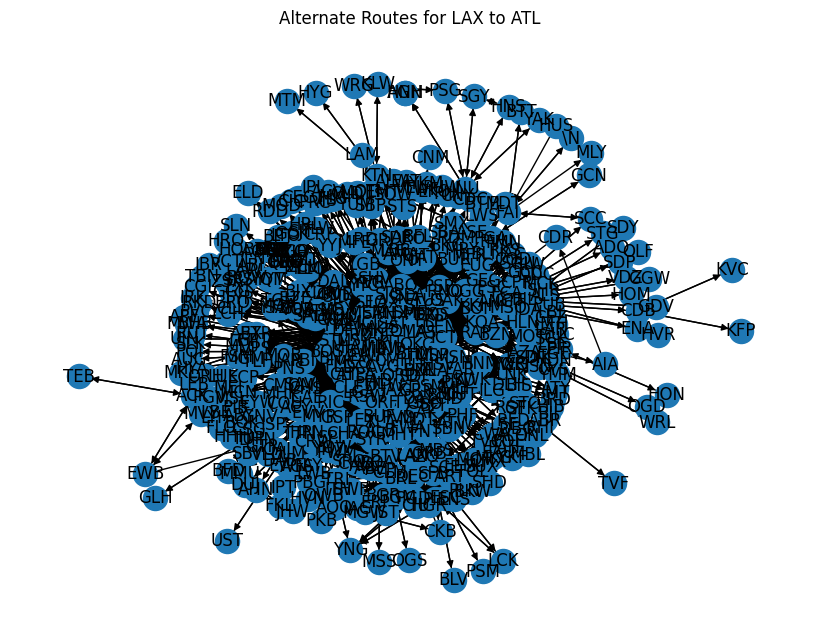

In [21]:
# Plotting the results of the network
plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G)

# Use the paths made above
for path in paths:
    edges_in_path = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_path, width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=path)

nx.draw(G, pos, with_labels=True)

plt.title('Alternate Routes for ' + startAirport + ' to ' + endAirport)
plt.show()

In [22]:
# Choose what variables we want to cluster
variable1 = 'TOTAL_DIST'
variable2 = 'TOTAL_TIME'
variable3 = 'ROUTE_VERSATILITY_SCORE'

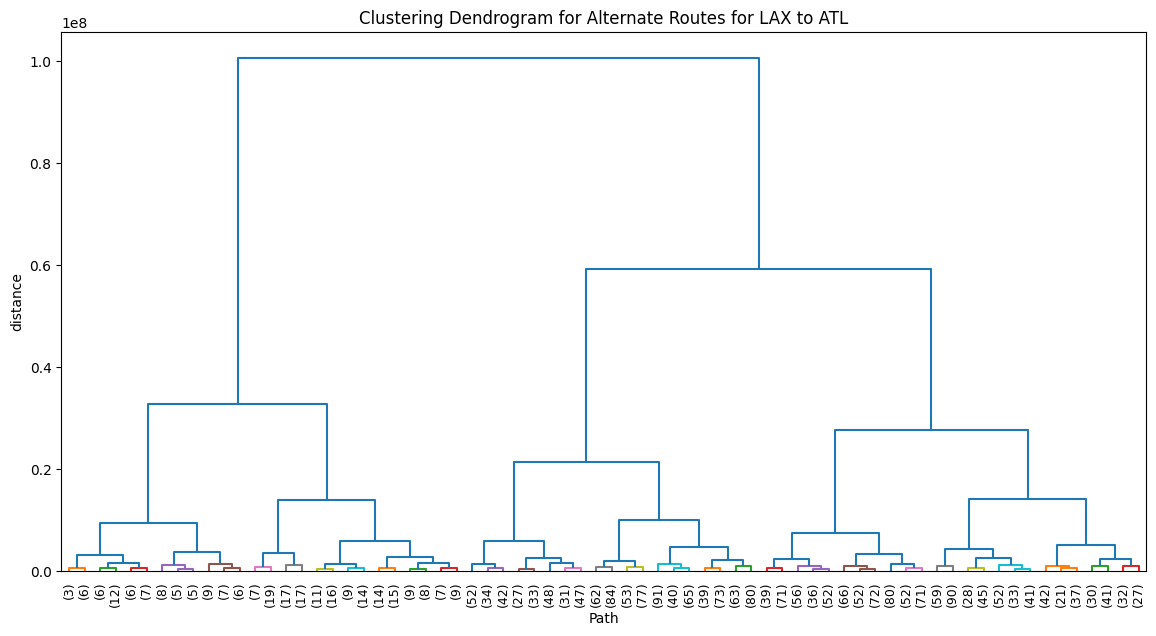

In [23]:
# Set up the dendrogram
X_features = routes[[variable1, variable2, variable3]]
y_labels = pd.DataFrame(routes[['PATH']])

linkage_matrix = linkage(X_features, 'ward')
plot = plt.figure(figsize=(14, 7))
labels = list(y_labels['PATH'])

dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  
    p=70, # Changes where the bottom of the dendrogram cuts off for readability sake
    leaf_rotation=90., 
    leaf_font_size=9.,
    color_threshold=(1.3 * 10**6), # Use this to differentiate clusters below a specified distance to aid in cluster quantity selection 
    labels= labels
)
plt.title('Clustering Dendrogram for Alternate Routes for ' + startAirport + ' to ' + endAirport)
plt.xlabel('Path')
plt.ylabel('distance')
plt.show()

In [24]:
# Set Desired Amount of Clusters to Test, looks like around 36 from our dendrogram coloring tweaking
clusterCount = 34

model = AgglomerativeClustering(linkage="ward", n_clusters=clusterCount)

# Fit the Model
model.fit(X_features)
predicted_labels = model.labels_

routes['HCCluster'] = predicted_labels

# Find what cluster contains our optimal route (direct path) and gather all results of that cluster
HCoptimalReplacementRoutes = routes.loc[routes['HCCluster'] == routes.loc[routes['PATH'].astype(str) == optimalPath, 'HCCluster'].item()]

print("Results in Probable Optimal Cluster - ", HCoptimalReplacementRoutes.shape[0])
print("\nResults:")
print(HCoptimalReplacementRoutes.head())

Results in Probable Optimal Cluster -  48

Results:
                   PATH  STOPS  TOTAL_DIST  TOTAL_TIME  \
0       [LAX, MEM, ATL]    1.0   3543891.0    120452.0   
0  [LAX, PSP, DFW, ATL]    2.0   3627965.0    128813.0   
0  [LAX, PSP, PHX, ATL]    2.0   3543766.0    127535.0   
0  [LAX, YUM, PHX, ATL]    2.0   3678844.0    131241.0   
0       [LAX, OKC, ATL]    1.0   3547458.0    120420.0   

   ROUTE_VERSATILITY_SCORE  HCCluster  
0                10.333333         27  
0                47.750000         27  
0                25.250000         27  
0                21.500000         27  
0                 6.666667         27  


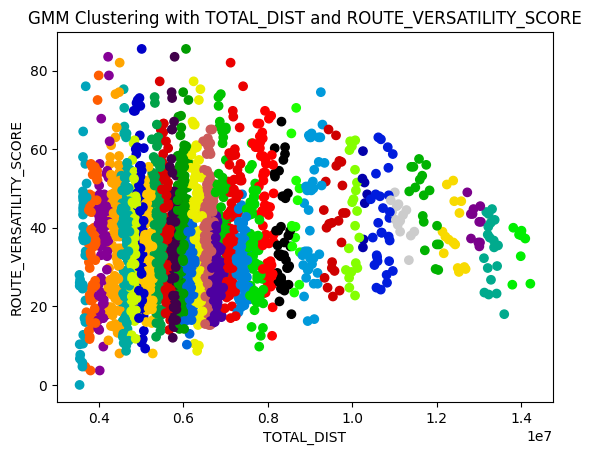

In [25]:
gmmData = routes[[variable1, variable3]]

# Fit GMM
gmm = GaussianMixture(n_components=clusterCount)
gmm.fit(gmmData)

# Predict the labels (cluster assignments)
labels = gmm.predict(gmmData)
routes['GMMCluster'] = labels

# Plot the results
plt.scatter(gmmData[[variable1]], gmmData[[variable3]], c=labels, cmap='nipy_spectral')
plt.xlabel(variable1)
plt.ylabel(variable3)
plt.title('GMM Clustering with ' + variable1 + ' and ' + variable3)
plt.show()

In [26]:
# Find what cluster contains our optimal route (direct path) and gather all results of that cluster
GMMoptimalReplacementRoutes = routes.loc[routes['GMMCluster'] == routes.loc[routes['PATH'].astype(str) == optimalPath, 'GMMCluster'].item()]

print("Results in Probable Optimal Cluster - ", GMMoptimalReplacementRoutes.shape[0])
print("\nResults:")
print(GMMoptimalReplacementRoutes.head())

Results in Probable Optimal Cluster -  46

Results:
                   PATH  STOPS  TOTAL_DIST  TOTAL_TIME  \
0       [LAX, MEM, ATL]    1.0   3543891.0    120452.0   
0  [LAX, PSP, DFW, ATL]    2.0   3627965.0    128813.0   
0  [LAX, PSP, PHX, ATL]    2.0   3543766.0    127535.0   
0  [LAX, YUM, PHX, ATL]    2.0   3678844.0    131241.0   
0       [LAX, OKC, ATL]    1.0   3547458.0    120420.0   

   ROUTE_VERSATILITY_SCORE  HCCluster  GMMCluster  
0                10.333333         27          11  
0                47.750000         27          11  
0                25.250000         27          11  
0                21.500000         27          11  
0                 6.666667         27          11  


In [27]:
# Ability to see all optimal replacement routes for both methods at once
allOptimalReplacementRoutes = routes.loc[(routes['HCCluster'] == routes.loc[routes['PATH'].astype(str) == optimalPath, 'HCCluster'].item()) | (routes['GMMCluster'] == routes.loc[routes['PATH'].astype(str) == optimalPath, 'GMMCluster'].item())]

print(allOptimalReplacementRoutes)

                   PATH  STOPS  TOTAL_DIST  TOTAL_TIME  \
0       [LAX, MEM, ATL]    1.0   3543891.0    120452.0   
0  [LAX, PSP, DFW, ATL]    2.0   3627965.0    128813.0   
0  [LAX, PSP, PHX, ATL]    2.0   3543766.0    127535.0   
0  [LAX, YUM, PHX, ATL]    2.0   3678844.0    131241.0   
0       [LAX, OKC, ATL]    1.0   3547458.0    120420.0   
0  [LAX, SAF, DFW, ATL]    2.0   3694821.0    131806.0   
0       [LAX, SAN, ATL]    1.0   3657649.0    123154.0   
0  [LAX, SAN, DFW, ATL]    2.0   3676796.0    129383.0   
0  [LAX, SAN, ABQ, ATL]    2.0   3702577.0    132087.0   
0  [LAX, SAN, PHX, ATL]    2.0   3688386.0    131558.0   
0  [LAX, SAN, TUS, ATL]    2.0   3662157.0    129170.0   
0       [LAX, XNA, ATL]    1.0   3674473.0    125549.0   
0       [LAX, DFW, ATL]    1.0   3621752.0    122465.0   
0  [LAX, DFW, BHM, ATL]    2.0   3628055.0    128407.0   
0  [LAX, DFW, JAN, ATL]    2.0   3630779.0    128564.0   
0  [LAX, DFW, LIT, ATL]    2.0   3705919.0    131387.0   
0  [LAX, DFW, 